In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path='/content/drive/MyDrive/Audio_Tagging_MLSP'
import numpy as np 
import os
import glob
import pandas as pd
import librosa
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from keras.preprocessing import image
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score, hamming_loss, multilabel_confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
def to_multihot(eventroll):
    """
    Parameters
    ----------
    eventroll : np.array
        Eventroll matrix of shape=(11, 1000).
    
    Returns
    -------
    np.array
        A multihot vector of shape=(10,)
    """
    
    # findout active events:
    active_events = (eventroll.sum(axis=1) >= 0.5).astype('float')
    
    # remove silence class:
    return np.delete(active_events, 8)

In [ ]:
path='/content/drive/MyDrive/Audio_Tagging_MLSP'
X_train=np.load(os.path.join(path, "X_train.npy"))
X_test=np.load(os.path.join(path, "X_test.npy"))
Y_train=np.load(os.path.join(path, "Y_train.npy"))
Y_test=np.load(os.path.join(path, "Y_test.npy"))

In [ ]:
X_train=X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
X_train.shape
X_test=X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))
X_test.shape

(2000, 64, 1000, 1)

In [ ]:
def macro_f1(y, y_hat, thresh=0.1):
    """Compute the macro F1-score on a batch of observations (average F1 across labels)
    
    Args:
        y (int32 Tensor): labels array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        thresh: probability value above which we predict positive
        
    Returns:
        macro_f1 (scalar Tensor): value of macro F1 for the batch
    """
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    macro_f1 = tf.reduce_mean(f1)
    return macro_f1

In [ ]:
def multi_label_classifier(input_shape):
    print(input_shape) 
#     inputs = tf.keras.Input(shape=input_shape)
    num_classes = 10 # categories of sound
    model = keras.models.Sequential()
    # input layer
    model.add(keras.layers.Flatten(input_shape = input_shape)),
    
    # first hidden layer
    model.add(keras.layers.Dense(1024, activation="relu")),
    
    # second hidden layer
    model.add(keras.layers.Dense(512, activation="relu")),
    
    # third hidden layer
    model.add(keras.layers.Dense(256, activation="relu")),
    
    # fourth hidden layer
    model.add(keras.layers.Dense(128, activation="relu"))
    
    # output layer
    model.add(keras.layers.Dense(num_classes, activation='sigmoid')),
  
    model.compile(optimizer=keras.optimizers.Adam(1e-4), 
        loss='binary_crossentropy', # one-hot encoding for binary arrays
        metrics=[macro_f1]) # provides better estimates of accuracy for one-hot labels
    return model

In [ ]:
path='/content/drive/MyDrive/Audio_Tagging_MLSP/NN_model'
filepath=os.path.join(path, "./thresh_0.1_NN_model.h5")
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath,
    monitor='macro_f1',
    mode='max',
    save_best_only=True,
    )

In [ ]:
from matplotlib import pyplot as plt
# model = multi_label_classifier(input_shape=X_train.shape[1:])
model = tf.keras.models.load_model('/content/drive/MyDrive/Audio_Tagging_MLSP/NN_model/thresh_0.1_NN_model47.h5',custom_objects={"macro_f1":macro_f1})
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 64000)             0         
                                                                 
 dense (Dense)               (None, 1024)              65537024  
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                                 
 dense_4 (Dense)             (None, 10)                1290      
                                                                 
Total params: 66,227,338
Trainable params: 66,227,338
No

In [ ]:
history=model.fit(X_train, Y_train, validation_data=(X_test, Y_test), batch_size=32, epochs=80, verbose = 2, callbacks=[model_checkpoint_callback])

Epoch 1/80
313/313 - 12s - loss: 0.0363 - macro_f1: 0.9136 - val_loss: 1.5402 - val_macro_f1: 0.1977 - 12s/epoch - 38ms/step
Epoch 2/80
313/313 - 7s - loss: 0.0381 - macro_f1: 0.9119 - val_loss: 1.5903 - val_macro_f1: 0.1921 - 7s/epoch - 23ms/step
Epoch 3/80
313/313 - 10s - loss: 0.0291 - macro_f1: 0.9208 - val_loss: 1.6918 - val_macro_f1: 0.1961 - 10s/epoch - 33ms/step
Epoch 4/80
313/313 - 11s - loss: 0.0224 - macro_f1: 0.9385 - val_loss: 1.6369 - val_macro_f1: 0.1897 - 11s/epoch - 35ms/step
Epoch 5/80
313/313 - 7s - loss: 0.0370 - macro_f1: 0.9121 - val_loss: 1.6894 - val_macro_f1: 0.1892 - 7s/epoch - 22ms/step
Epoch 6/80
313/313 - 6s - loss: 0.0322 - macro_f1: 0.9225 - val_loss: 1.7345 - val_macro_f1: 0.1954 - 6s/epoch - 19ms/step
Epoch 7/80
313/313 - 6s - loss: 0.0296 - macro_f1: 0.9221 - val_loss: 1.7419 - val_macro_f1: 0.1863 - 6s/epoch - 19ms/step
Epoch 8/80
313/313 - 6s - loss: 0.0341 - macro_f1: 0.9211 - val_loss: 1.7521 - val_macro_f1: 0.1916 - 6s/epoch - 21ms/step
Epoch 9/80

In [ ]:
def apply_threshold_in_predictions(Y_pred, threshold):
  for arr in Y_pred:
    j=0
    for _ in arr:
      if(_>=threshold):
        arr[j] = 1
      else:
        arr[j] = 0
      j=j+1
  
  return Y_pred

In [ ]:
check_model = tf.keras.models.load_model('/content/drive/MyDrive/Audio_Tagging_MLSP/NN_model/thresh_0.1_NN_model.h5',custom_objects={"macro_f1":macro_f1})

In [ ]:
Y_pred = check_model.predict(X_test)

63/63 [==============================] - 1s 6ms/step


In [ ]:
from sklearn.metrics import classification_report
print(apply_threshold_in_predictions(Y_pred, 0.1))
print(classification_report(Y_test, Y_pred))

[[0. 0. 1. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [1. 0. 0. ... 0. 1. 0.]
 [0. 0. 1. ... 0. 1. 0.]]
              precision    recall  f1-score   support

           0       0.32      0.33      0.33       392
           1       0.40      0.21      0.27       436
           2       0.22      0.24      0.23       274
           3       0.28      0.24      0.26       444
           4       0.29      0.34      0.32       306
           5       0.51      0.27      0.36       221
           6       0.41      0.36      0.39       130
           7       0.18      0.31      0.23       143
           8       0.63      0.98      0.77      1246
           9       0.29      0.19      0.23       151

   micro avg       0.45      0.51      0.48      3743
   macro avg       0.35      0.35      0.34      3743
weighted avg       0.43      0.51      0.45      3743
 samples avg       0.48      0.49      0.45      3743



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


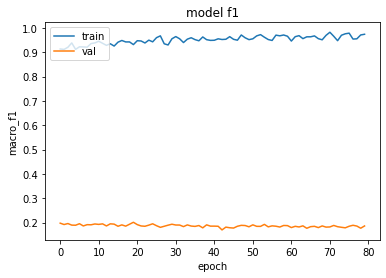

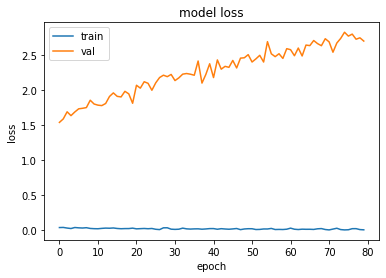

In [ ]:
from matplotlib import pyplot as plt
model.metrics_names
plt.plot(history.history['macro_f1'])
plt.plot(history.history['val_macro_f1'])
plt.title('model f1')
plt.ylabel('macro_f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()